In [65]:
import stanfordnlp
import graphviz
import networkx as nx
import matplotlib.pyplot as plt
import copy
%matplotlib inline

### Загрузка модели

In [54]:
#stanfordnlp.download('ru') 

Using the default treebank "ru_syntagrus" for language "ru".
Would you like to download the models for: ru_syntagrus now? (Y/n)
Y

Default download directory: /home/alex/stanfordnlp_resources
Hit enter to continue or type an alternate directory.


Download location: /home/alex/stanfordnlp_resources/ru_syntagrus_models.zip


100%|██████████| 236M/236M [06:12<00:00, 677kB/s]  



Download complete.  Models saved to: /home/alex/stanfordnlp_resources/ru_syntagrus_models.zip
Extracting models file for: ru_syntagrus
Cleaning up...Done.


### Инициализация пайплайна nlp, загрузка моделей в память

In [2]:
nlp = stanfordnlp.Pipeline(lang='ru')

Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/home/alex/stanfordnlp_resources/ru_syntagrus_models/ru_syntagrus_tokenizer.pt', 'lang': 'ru', 'shorthand': 'ru_syntagrus', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/home/alex/stanfordnlp_resources/ru_syntagrus_models/ru_syntagrus_tagger.pt', 'pretrain_path': '/home/alex/stanfordnlp_resources/ru_syntagrus_models/ru_syntagrus.pretrain.pt', 'lang': 'ru', 'shorthand': 'ru_syntagrus', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/home/alex/stanfordnlp_resources/ru_syntagrus_models/ru_syntagrus_lemmatizer.pt', 'lang': 'ru', 'shorthand': 'ru_syntagrus', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
---
Loading: depparse
With settings: 
{'model_path': '/home/alex/stanfordnlp_resources/ru_syntagrus_models/ru_syntagrus_parser.pt', 'p

### Запуск пайплайна nlp на документе
Документ - текст, состоящий из нескольких предложений.

In [3]:
doc = nlp("Перед красным деревянным столом стоит черный металлический стул .")

### Печать зависимостей в первом предложении

In [4]:
doc.sentences[0].print_dependencies()

('Перед', '4', 'case')
('красным', '4', 'amod')
('деревянным', '4', 'amod')
('столом', '5', 'obl')
('стоит', '0', 'root')
('черный', '8', 'amod')
('металлический', '8', 'amod')
('стул', '5', 'nsubj')
('.', '5', 'punct')


### Полная информация о зависимостях и атрибутах токенов

In [73]:
doc.sentences[0].dependencies

[(<Word index=4;text=столом;lemma=стол;upos=NOUN;xpos=_;feats=Animacy=Inan|Case=Ins|Gender=Masc|Number=Sing;governor=5;dependency_relation=obl>,
  'case',
  <Word index=1;text=Перед;lemma=перед;upos=ADP;xpos=_;feats=_;governor=4;dependency_relation=case>),
 (<Word index=4;text=столом;lemma=стол;upos=NOUN;xpos=_;feats=Animacy=Inan|Case=Ins|Gender=Masc|Number=Sing;governor=5;dependency_relation=obl>,
  'amod',
  <Word index=2;text=красным;lemma=красный;upos=ADJ;xpos=_;feats=Case=Ins|Degree=Pos|Gender=Masc|Number=Sing;governor=4;dependency_relation=amod>),
 (<Word index=4;text=столом;lemma=стол;upos=NOUN;xpos=_;feats=Animacy=Inan|Case=Ins|Gender=Masc|Number=Sing;governor=5;dependency_relation=obl>,
  'amod',
  <Word index=3;text=деревянным;lemma=деревянный;upos=ADJ;xpos=_;feats=Case=Ins|Degree=Pos|Gender=Masc|Number=Sing;governor=4;dependency_relation=amod>),
 (<Word index=5;text=стоит;lemma=стоить;upos=VERB;xpos=_;feats=Aspect=Imp|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voi

### Класс для преобразования результата парсинга в направленный граф и работы с ним

In [109]:
class ParseTree:
    def __init__(self, dep_parse):
        self.DG = self.create_dg(dep_parse) # граф из networkx - физическая структура данных
        self.VDG = self.create_vdg(self.DG) # визуальный граф из graphvis - тлько для визуализации и отладки
        
    def word2dct(self, word):
        dct = copy.copy(word.__dict__)
        del dct['_index'], \
            dct['_governor'], \
            dct['_dependency_relation'], \
            dct['_parent_token']
        dct = dict((key.replace('_',''), value) for (key, value) in dct.items())
        return dct
        
    def create_dg(self, dep_parse):
        DG = nx.DiGraph()
        for dep in dep_parse:
            if dep[2].upos != 'PUNCT':
                attributes = self.word2dct(dep[2])
                DG.add_node(dep[2].index, **attributes)
        for dep in dep_parse:
            if dep[0].text != 'ROOT' and dep[2].upos != 'PUNCT':
                DG.add_edge(dep[0].index, dep[2].index, dependency_relation = dep[1])
        return DG
    
    def create_vdg(self, dg):
        VDG = graphviz.Digraph()
        for node in dg.nodes(data=True):
            VDG.node(node[0], node[1]['text'])
        for edge in dg.edges(data=True):
            VDG.edge(edge[0], edge[1], edge[2]['dependency_relation'])
        return VDG
    
    def create_subgraph(self, root_node_index):
        sub_nodes = list(pt.DG.successors(root_node_index)) + [root_node_index]
        sg = self.DG.subgraph(sub_nodes)
        vsg = self.create_vdg(sg)
        return sg, vsg

In [101]:
pt = ParseTree(doc.sentences[0].dependencies)

#### Узлы, ребра и их атрибуты

In [102]:
for elem in pt.DG.nodes(data=True):
    print(elem)

('1', {'text': 'Перед', 'lemma': 'перед', 'upos': 'ADP', 'xpos': '_', 'feats': '_'})
('2', {'text': 'красным', 'lemma': 'красный', 'upos': 'ADJ', 'xpos': '_', 'feats': 'Case=Ins|Degree=Pos|Gender=Masc|Number=Sing'})
('3', {'text': 'деревянным', 'lemma': 'деревянный', 'upos': 'ADJ', 'xpos': '_', 'feats': 'Case=Ins|Degree=Pos|Gender=Masc|Number=Sing'})
('4', {'text': 'столом', 'lemma': 'стол', 'upos': 'NOUN', 'xpos': '_', 'feats': 'Animacy=Inan|Case=Ins|Gender=Masc|Number=Sing'})
('5', {'text': 'стоит', 'lemma': 'стоить', 'upos': 'VERB', 'xpos': '_', 'feats': 'Aspect=Imp|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act'})
('6', {'text': 'черный', 'lemma': 'черный', 'upos': 'ADJ', 'xpos': '_', 'feats': 'Case=Nom|Degree=Pos|Gender=Masc|Number=Sing'})
('7', {'text': 'металлический', 'lemma': 'металлический', 'upos': 'ADJ', 'xpos': '_', 'feats': 'Case=Nom|Degree=Pos|Gender=Masc|Number=Sing'})
('8', {'text': 'стул', 'lemma': 'стул', 'upos': 'NOUN', 'xpos': '_', 'feats': 'Animac

In [103]:
for elem in pt.DG.edges(data=True):
    print(elem)

('4', '1', {'dependency_relation': 'case'})
('4', '2', {'dependency_relation': 'amod'})
('4', '3', {'dependency_relation': 'amod'})
('5', '4', {'dependency_relation': 'obl'})
('5', '8', {'dependency_relation': 'nsubj'})
('8', '6', {'dependency_relation': 'amod'})
('8', '7', {'dependency_relation': 'amod'})


### Визуализация физического графа из networkx при помощи matplotlib

In [104]:
labels=dict((n,d['text']) for n,d in pt.DG.nodes(data=True))

/home/alex/anaconda3/envs/NLP/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/alex/anaconda3/envs/NLP/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


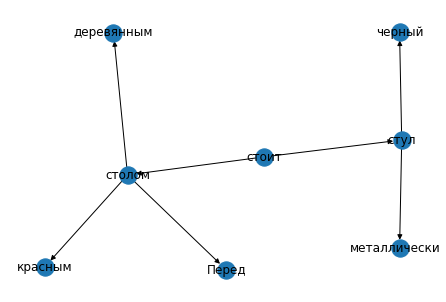

In [105]:
nx.draw(pt.DG, labels = labels)

### Визуализация того же графа при помощи graphviz

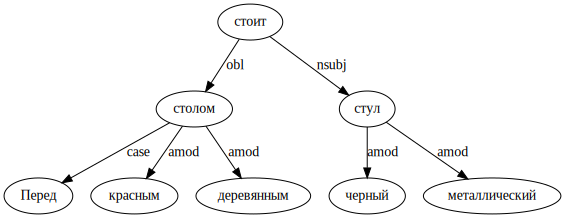

In [106]:
pt.VDG

### Создание подграфа
Создается подграф (поддерево), вершиной которого является стол, индекс узла, соответствующего слову "стол" - '4'

In [107]:
sg, vsg = pt.create_subgraph('4')

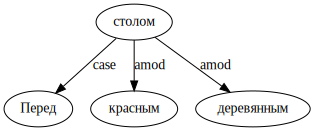

In [108]:
vsg